In [20]:
%matplotlib inline

In [21]:
import glob
import numpy as np
import os
import math

In [22]:
from matplotlib import pyplot as plt

In [23]:
filenames = sorted(glob.glob('*.xyz'))

(0, 300)

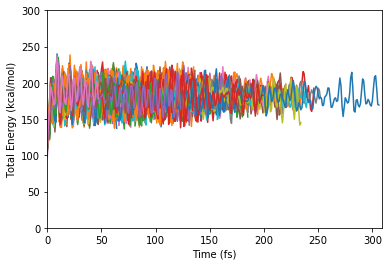

In [27]:
fig,ax = plt.subplots()
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Total Energy (kcal/mol)')
x1=[]

###Record PE at each point
for f in filenames:
    xyz = open(f)
    n_atoms = int(xyz.readline())
    atoms=[]
    PE=[]
    coordinates = []
    ###Each point along the IRC/traj will be stored as an entry in a 3D array called coordinates_all
    coordinates_all = []
    for line in xyz:
        if len(PE)>3:
            if PE[len(PE)-1] == PE[0]:
                break
        splitline=line.split()
        if len(splitline)>4:
            energy=splitline[0]
            PE.append(float(energy))
        elif len(splitline)==4:
            atom,x,y,z= splitline
            if len(atoms)<n_atoms:
                atoms.append(atom)
            coordinates.append([float(x), float(y), float(z)])
        elif len(splitline)==1:
            if len(coordinates) != 0:
                coordinates_all.append(coordinates)
                coordinates=[]
        else:
            coordinates_all.append(coordinates)           

    n_ircpoints=len(coordinates_all)     
    #print(coordinates_all)
    #print("Traj length: %d fs" % n_ircpoints)
    #print(atoms)

    ###Print ERROR if length of coordinate section doesn't match number of atoms specified at beginning of xyz file        
    if len(atoms) != n_atoms:
        print("ERROR: file contains %d atoms instead of the stated number %d" % (n_atoms, len(atoms)))
        print("number of atoms in file: %d" % n_atoms)
        print("number of coordinates:   %d" % len(coordinates))
       
    PEK=[]
    for i in range(0,len(PE)):
        PEKi=627.51*(PE[i]-PE[0])
        PEK.append(PEKi)
    
    ###Calculate KE at each point
    masses=[]
    for atom in atoms:
        if atom == "H":
            masses.append(1.0079)
        elif atom == "C":
            masses.append(12.0107)
        elif atom == "N":
            masses.append(14.0067)
        elif atom == "O":
            masses.append(15.9994)
        elif atom == "F":
            masses.append(18.9984)
        elif atom == "S":
            masses.append(32.065)
        else:
            masses.append([0])

    conver1=4.184*(10**26)
    timestep=10**(-15)
    Avo_num=6.022*(10**23)
    #print(1/(conver1*timestep**2))
    
    ###Calculate velocity of each atom
    vel=[]
    #v(t)=(r(t + dt)-r(t-dt))/2dt
    for i in range (1,len(coordinates_all)-1):
        veli=np.subtract(coordinates_all[i+1],coordinates_all[i-1])/(2*timestep)
        vel.append(veli)
       
    ###Calculate KE of each atom
    KE=[]
    for j in range (0,len(coordinates_all)-2):
        KEi=0
        for i in range(0,n_atoms-1):
            #KEij=0.5*masses[i]*(vel[i][1]**2 + vel[i][2]**2 + vel[i][3]**2)/((timestep**2)*conver1)
            #KEij=0.5*masses[i]*(vel[j][i][0]**2 + vel[j][i][1]**2 + vel[j][i][2]**2)/(conver1)
            #print(vel[j][i])
            KEij=0.5*masses[i]*(np.dot(vel[j][i],vel[j][i]))/conver1
            #KEij=0.5*masses[i]*Avo_num*(np.dot(vel[j][i],vel[j][i]))/conver1*timestep**2
            KEi=KEi+KEij
        KE.append(KEi)
    #print(KE)
    #print(PEK)
    
    x=np.arange(n_ircpoints-2)
    x1.append(n_ircpoints)
    y=[]
    for i in range (0,len(KE)):
        yi = PEK[i] + KE[i]
        y.append(yi)
    ax.plot(x,y)

ax.set_xlim(0,max(x1))
ax.set_ylim(0,300)